<a href="https://www.kaggle.com/code/quangnhatbui/moa-comp?scriptVersionId=132523208" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
train_features = pd.read_csv("/kaggle/input/lish-moa/train_features.csv")
test_features  = pd.read_csv("/kaggle/input/lish-moa/test_features.csv")
train_targets = pd.read_csv("/kaggle/input/lish-moa/train_targets_scored.csv")

In [2]:
import tensorflow as tf
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.


AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
#REPLICAS = 8
print(f'REPLICAS: {REPLICAS}')

REPLICAS: 1


In [3]:
ctrl_idxs = test_features[test_features.cp_type != 'trt_cp' ].index

In [4]:
train_features1 = train_features.copy()
test_features1 = test_features.copy()
train_targets1 = train_targets.copy()

In [5]:
sample_sub = pd.read_csv("/kaggle/input/lish-moa/sample_submission.csv")

In [6]:
print(train_features1.shape)
print(train_targets1.shape)
print(sample_sub.shape)

(23814, 876)
(23814, 207)
(3982, 207)


In [7]:
train_features.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [8]:
sample_sub.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_0004d9e33,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
1,id_001897cda,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
2,id_002429b5b,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
3,id_00276f245,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
4,id_0027f1083,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5


In [9]:
train_targets.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss

In [11]:
train_features.cp_type.value_counts()

trt_cp         21948
ctl_vehicle     1866
Name: cp_type, dtype: int64

In [12]:
# Checking if there is nan or not
a = []
for x,y in enumerate(train_features1.isna().sum()):
    if y != 0:
        a.append(x)
        
b = []
for x,y in enumerate(test_features1.isna().sum()):
    if y != 0:
        a.append(x)
c = []
for x,y in enumerate(train_targets1.isna().sum()):
    if y != 0:
        a.append(x)
print(a, b ,c)

[] [] []


In [13]:
train_features1

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,id_fffb1ceed,trt_cp,24,D2,0.1394,-0.0636,-0.1112,-0.5080,-0.4713,0.7201,...,0.1969,0.0262,-0.8121,0.3434,0.5372,-0.3246,0.0631,0.9171,0.5258,0.4680
23810,id_fffb70c0c,trt_cp,24,D2,-1.3260,0.3478,-0.3743,0.9905,-0.7178,0.6621,...,0.4286,0.4426,0.0423,-0.3195,-0.8086,-0.9798,-0.2084,-0.1224,-0.2715,0.3689
23811,id_fffc1c3f4,ctl_vehicle,48,D2,0.3942,0.3756,0.3109,-0.7389,0.5505,-0.0159,...,0.5409,0.3755,0.7343,0.2807,0.4116,0.6422,0.2256,0.7592,0.6656,0.3808
23812,id_fffcb9e7c,trt_cp,24,D1,0.6660,0.2324,0.4392,0.2044,0.8531,-0.0343,...,-0.1105,0.4258,-0.2012,0.1506,1.5230,0.7101,0.1732,0.7015,-0.6290,0.0740


In [14]:
# train = train_features1[train_features1["cp_type"] != "ctl_vehicle"]
# test = test_features1[test_features1["cp_type"] != "ctl_vehicle"]
train_features1.at[train_features1['cp_type'].str.contains('ctl_vehicle'),train_features.filter(regex='-.*').columns] = 0.0

test_features1.at[test_features1['cp_type'].str.contains('ctl_vehicle'),test_features.filter(regex='-.*').columns] = 0.0

In [15]:
train = train_features1
test = test_features1

In [16]:
n_target = len(train_targets1.columns[1:])

In [17]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
def preprocessing(df):
    labelencoder = LabelEncoder()
    std_scaler = StandardScaler()
    df["cp_dose"] = labelencoder.fit_transform(df["cp_dose"])
    df["cp_type"] = labelencoder.fit_transform(df["cp_type"])
    df["cp_time"] = std_scaler.fit_transform(df["cp_time"].values.reshape(-1,1))
    df.drop("sig_id", axis=1, inplace=True)
    return df
train = preprocessing(train)
test = preprocessing(test)

In [18]:
test

,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,1,-1.237919,0,-0.5458,0.1306,-0.5135,0.4408,1.5500,-0.1644,-0.2140,...,0.0981,0.7978,-0.1430,-0.2067,-0.2303,-0.1193,0.0210,-0.0502,0.1510,-0.7750
1,1,1.234814,0,-0.1829,0.2320,1.2080,-0.4522,-0.3652,-0.3319,-1.8820,...,-0.1190,-0.1852,-1.0310,-1.3670,-0.3690,-0.5382,0.0359,-0.4764,-1.3810,-0.7300
2,0,-1.237919,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,1,-1.237919,1,0.4828,0.1955,0.3825,0.4244,-0.5855,-1.2020,0.5998,...,0.1260,0.1570,-0.1784,-1.1200,-0.4325,-0.9005,0.8131,-0.1305,0.5645,-0.5809
4,1,-0.001552,0,-0.3979,-1.2680,1.9130,0.2057,-0.5864,-0.0166,0.5128,...,0.4965,0.7578,-0.1580,1.0510,0.5742,1.0900,-0.2962,-0.5313,0.9931,1.8380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3977,1,-1.237919,0,0.4571,-0.5743,3.3930,-0.6202,0.8557,1.6240,0.0640,...,-1.1790,-0.6422,-0.4367,0.0159,-0.6539,-0.4791,-1.2680,-1.1280,-0.4167,-0.6600
3978,1,-1.237919,0,-0.5885,-0.2548,2.5850,0.3456,0.4401,0.3107,-0.7437,...,0.0210,0.5780,-0.5888,0.8057,0.9312,1.2730,0.2614,-0.2790,-0.0131,-0.0934
3979,1,1.234814,0,-0.3985,-0.1554,0.2677,-0.6813,0.0152,0.4791,-0.0166,...,0.4418,0.9153,-0.1862,0.4049,0.9568,0.4666,0.0461,0.5888,-0.4205,-0.1504
3980,1,-0.001552,1,-1.0960,-1.7750,-0.3977,1.0160,-1.3350,-0.2207,-0.3611,...,0.3079,-0.4473,-0.8192,0.7785,0.3133,0.1286,-0.2618,0.5074,0.7430,-0.0484


In [19]:
print(train.shape)
print(train_targets1.shape)

(23814, 875)
(23814, 207)


In [20]:
y_train = train_targets1
y_train.drop("sig_id", axis=1, inplace=True)

In [21]:
train_targets1.iloc[2, :].value_counts()

0    203
1      3
Name: 2, dtype: int64

In [22]:
# def get_keras_model(input_dim=875, output_dim=206):
    
#     model = tf.keras.Sequential([
#     tf.keras.layers.Dense(512, input_dim=input_dim, activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dropout(.25),
#     tf.keras.layers.Dense(1024, activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dropout(.25),
#     tf.keras.layers.Dense(1024, activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dropout(.25),
#     tf.keras.layers.Dense(512, activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dropout(.25),
#     tf.keras.layers.Dense(output_dim, activation='sigmoid')
#     ])
#     return model

In [23]:
# def get_keras_model(input_dim=875, output_dim=206):
    
#     model = tf.keras.Sequential([
#     tf.keras.layers.Input(input_dim),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(4096, activation="relu"),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(4096, activation="relu"),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(4096, activation="relu"),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(2096, activation="relu"),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(2096, activation="relu"),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(2096, activation="relu"),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(1048, activation="relu"),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(1048, activation="relu"),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(1048, activation="relu"),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(512, activation="relu"),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(512, activation="relu"),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(512, activation="relu"),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(206, activation="sigmoid")])
#     return model

In [24]:
import tensorflow_addons as tfa
from tensorflow.keras import Model, layers
def get_keras_model(input_dim=875, output_dim=206):
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.BatchNormalization(input_shape=(input_dim,)))
    model.add(tfa.layers.WeightNormalization(layers.Dense(2048, activation='elu')))
    model.add(tf.keras.layers.Dropout(.5))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tfa.layers.WeightNormalization(layers.Dense(2048 // 2, activation='elu')))
    model.add(tf.keras.layers.Dropout(.5))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tfa.layers.WeightNormalization(layers.Dense(2048 // 4, activation='elu')))
    model.add(tf.keras.layers.Dropout(.5))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tfa.layers.WeightNormalization(layers.Dense(206, activation=None)))
    return model

/opt/conda/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.3.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [25]:
model = get_keras_model()

In [26]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])

In [27]:
history = model.fit(train, y_train, validation_split=0.2, epochs=10, verbose=2).history

Epoch 1/10
596/596 - 5s - loss: 1.0164 - accuracy: 0.0044 - val_loss: 0.2210 - val_accuracy: 0.0017
Epoch 2/10
596/596 - 4s - loss: 0.3108 - accuracy: 0.0044 - val_loss: 0.2458 - val_accuracy: 0.0031
Epoch 3/10
596/596 - 4s - loss: 0.1732 - accuracy: 0.0037 - val_loss: 0.0936 - val_accuracy: 0.0034
Epoch 4/10
596/596 - 4s - loss: 0.1076 - accuracy: 0.0056 - val_loss: 0.0711 - val_accuracy: 0.0103
Epoch 5/10
596/596 - 4s - loss: 0.0810 - accuracy: 0.0067 - val_loss: 0.0571 - val_accuracy: 0.0092
Epoch 6/10
596/596 - 4s - loss: 0.0632 - accuracy: 0.0047 - val_loss: 0.0577 - val_accuracy: 0.0132
Epoch 7/10
596/596 - 4s - loss: 0.0599 - accuracy: 0.0069 - val_loss: 0.0524 - val_accuracy: 0.0462
Epoch 8/10
596/596 - 4s - loss: 0.0573 - accuracy: 0.0139 - val_loss: 0.0507 - val_accuracy: 0.0376
Epoch 9/10
596/596 - 4s - loss: 0.0529 - accuracy: 0.0140 - val_loss: 0.0522 - val_accuracy: 0.0176
Epoch 10/10
596/596 - 4s - loss: 0.0522 - accuracy: 0.0069 - val_loss: 0.0513 - val_accuracy: 0.0174

In [28]:
pred = model.predict(test)

In [29]:
# pred = []
# for x in range(5):
#     history = model.fit(train, y_train, validation_split=0.2, epochs=30, verbose=2).history
#     if len(pred) == 0: 
#         pred = model.predict(test)
#     else:
#         pred += model.predict(test)

In [30]:
# with strategy.scope():  
# #     pred = []
#     model = get_keras_model()
#     model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])
#     history = model.fit(train, y_train, validation_split=0.2, epochs=30, verbose=2).history
# pred = model.predict(test)
# # # for x in range(5):
# # #     print(x)
# # #     history = model.fit(train, y_train, batch_size=30, epochs=25, verbose=1).history
# # #     if len(pred) == 0:
# # #         pred.append(model.predict(test)/5)
# # #     else:
# # #         pred += model.predict(test)/5

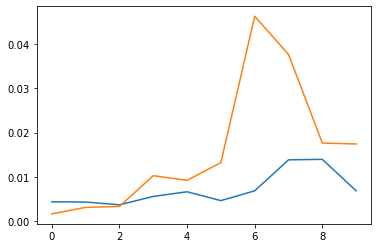

In [31]:
import matplotlib.pyplot as plt
plt.plot(history["accuracy"])
plt.plot(history["val_accuracy"])

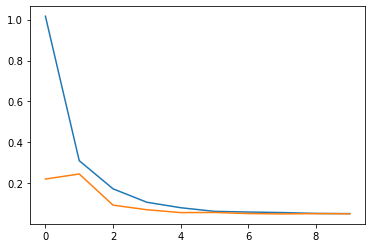

In [32]:
plt.plot(history["loss"])
plt.plot(history["val_loss"])

In [33]:
# pred = model.predict(test)

In [34]:
target_cols = train_targets.columns[1:]
test_preds = sample_sub.copy()
test_preds[target_cols] = 0

In [35]:
test_preds.loc[:, target_cols] = pred[0]

In [36]:
test_preds.loc[test["cp_type"]==0, target_cols] = 0
test_preds.to_csv("submission.csv", index=False)

In [37]:
test_preds

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_0004d9e33,-0.970299,-0.826935,-0.86375,-1.309304,-1.079001,-1.133412,-0.827114,-1.099079,-1.542902,...,-0.862335,-1.010113,-1.203989,-0.792931,-1.103667,-1.066642,-0.89027,-1.070498,-0.809859,-0.660491
1,id_001897cda,-0.970299,-0.826935,-0.86375,-1.309304,-1.079001,-1.133412,-0.827114,-1.099079,-1.542902,...,-0.862335,-1.010113,-1.203989,-0.792931,-1.103667,-1.066642,-0.89027,-1.070498,-0.809859,-0.660491
2,id_002429b5b,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
3,id_00276f245,-0.970299,-0.826935,-0.86375,-1.309304,-1.079001,-1.133412,-0.827114,-1.099079,-1.542902,...,-0.862335,-1.010113,-1.203989,-0.792931,-1.103667,-1.066642,-0.89027,-1.070498,-0.809859,-0.660491
4,id_0027f1083,-0.970299,-0.826935,-0.86375,-1.309304,-1.079001,-1.133412,-0.827114,-1.099079,-1.542902,...,-0.862335,-1.010113,-1.203989,-0.792931,-1.103667,-1.066642,-0.89027,-1.070498,-0.809859,-0.660491
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3977,id_ff7004b87,-0.970299,-0.826935,-0.86375,-1.309304,-1.079001,-1.133412,-0.827114,-1.099079,-1.542902,...,-0.862335,-1.010113,-1.203989,-0.792931,-1.103667,-1.066642,-0.89027,-1.070498,-0.809859,-0.660491
3978,id_ff925dd0d,-0.970299,-0.826935,-0.86375,-1.309304,-1.079001,-1.133412,-0.827114,-1.099079,-1.542902,...,-0.862335,-1.010113,-1.203989,-0.792931,-1.103667,-1.066642,-0.89027,-1.070498,-0.809859,-0.660491
3979,id_ffb710450,-0.970299,-0.826935,-0.86375,-1.309304,-1.079001,-1.133412,-0.827114,-1.099079,-1.542902,...,-0.862335,-1.010113,-1.203989,-0.792931,-1.103667,-1.066642,-0.89027,-1.070498,-0.809859,-0.660491
3980,id_ffbb869f2,-0.970299,-0.826935,-0.86375,-1.309304,-1.079001,-1.133412,-0.827114,-1.099079,-1.542902,...,-0.862335,-1.010113,-1.203989,-0.792931,-1.103667,-1.066642,-0.89027,-1.070498,-0.809859,-0.660491
